# CommonLit - Evaluate Student Summaries Dataset with TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the **CommonLit - Evaluate Student Summaries** dataset made available for this competition.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

# Import the libraries

In [6]:
import string
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.13.0
TensorFlow Decision Forests v1.5.0


# Load the Dataset

### Load the prompt csv

In [10]:
df_train_prompt = pd.read_csv('data/prompts_train.csv')
print("Full prompt train dataset shape is {}".format(df_train_prompt.shape))

Full prompt train dataset shape is (4, 4)


The data is composed of 4 columns and 4 entries. We can see all 4 dimensions of our dataset by using the following code:

In [11]:
df_train_prompt.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


### Load the summaries csv

In [12]:
df_train_summaries = pd.read_csv('data/summaries_train.csv')
print("Full summaries train dataset shape is {}".format(df_train_summaries.shape))

Full summaries train dataset shape is (7165, 5)


The data is composed of 5 columns and 7165 entries. We can see all 5 dimensions of our dataset by printing out the first 5 entries using the following code:

In [13]:
df_train_summaries.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


### Combine both summaries and prompt csv's based on prompt id

In [14]:
df_train = df_train_summaries.merge(df_train_prompt, on='prompt_id')
print("Full summaries train dataset shape is {}".format(df_train.shape))

Full summaries train dataset shape is (7165, 8)


The data is composed of 8 columns and 7165 entries. We can see all 8 dimensions of our dataset by printing out the first 5 entries using the following code:

In [15]:
df_train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


# Quick basic dataset exploration

In [16]:
df_train.describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   student_id       7165 non-null   object 
 1   prompt_id        7165 non-null   object 
 2   text             7165 non-null   object 
 3   content          7165 non-null   float64
 4   wording          7165 non-null   float64
 5   prompt_question  7165 non-null   object 
 6   prompt_title     7165 non-null   object 
 7   prompt_text      7165 non-null   object 
dtypes: float64(2), object(6)
memory usage: 447.9+ KB


# Label data distribution

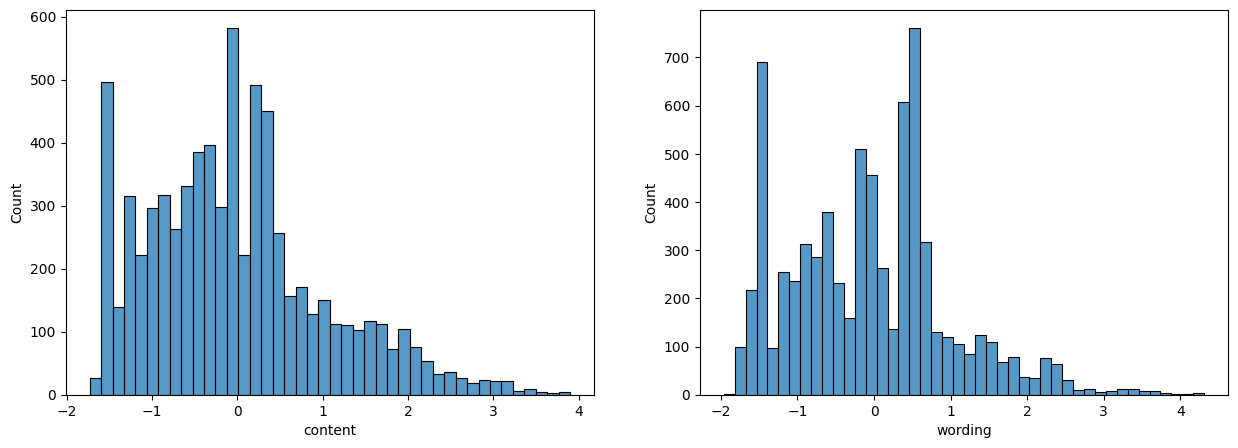

In [18]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=df_train, x='content')
plt.subplot(1, 2, 2)
sns.histplot(data=df_train, x='wording')
plt.show()

# LLM vs Non-LLM solutions

In this notebook, we won't be using an LLM model to embedd the text features. Instead we will calculate some numeric features from the text features like token count, length etc. Using these numeric features, we can create tabular data that can be used train our Model. This approach shows that sometimes non-LLM solutions can also give good results.   

# Preprocess the data

In [19]:
# Reference: https://www.kaggle.com/code/sercanyesiloz/commonlit-tf-idf-xgb-baseline#4.-Feature-Engineering

# A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, 
# both when indexing entries for searching and when retrieving them as the result of a search query.
# Count the stop words in the text.
def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

# Count the punctuations in the text.
# punctuation_set -> !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~
def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

# Count the digits in the text.
def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

# This function applies all the above preprocessing functions on a text feature.
def feature_engineer(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].apply(lambda x: len(x.split(' ')))
    dataframe[f'{feature}_length'] = dataframe[feature].apply(lambda x: len(x))
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
    dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    return dataframe

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
preprocessed_df = feature_engineer(df_train)
print("Full summaries train dataset shape is {}".format(preprocessed_df.shape))

Full summaries train dataset shape is (7165, 13)


The data is composed of 13 columns and 7165 entries. We can see all 13 dimensions of our dataset by printing out the first 5 entries using the following code:

In [23]:
preprocessed_df.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,61,346,25,3,0
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,206,1225,92,30,3
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,60,345,27,9,0
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,76,451,35,10,0
4,00d40ad10dc9,814d6b,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,27,145,12,2,0


In [24]:
preprocessed_df.describe()

,content,wording,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt
count,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000,7165.000000
mean,-0.014853,-0.063072,76.155618,418.776971,36.306769,9.355059,0.378786
std,1.043569,1.036048,54.538587,307.833685,25.813092,9.474397,0.937313
min,-1.729859,-1.962614,22.000000,114.000000,5.000000,0.000000,0.000000
25%,-0.799545,-0.872720,40.000000,216.000000,19.000000,4.000000,0.000000
50%,-0.093814,-0.081769,59.000000,320.000000,28.000000,6.000000,0.000000
75%,0.499660,0.503833,93.000000,513.000000,45.000000,12.000000,0.000000
max,3.900326,4.310693,651.000000,3940.000000,315.000000,162.000000,14.000000


## Extract feature columns

In [25]:
FEATURE_COLUMNS = preprocessed_df.drop(columns = ['student_id', 'prompt_id', 'text', 'prompt_question', 
                                           'prompt_title', 'prompt_text', 'content', 'wording'], axis = 1).columns.to_list()

In [26]:
FEATURE_COLUMNS

['text_word_cnt',
 'text_length',
 'text_stopword_cnt',
 'text_punct_cnt',
 'text_number_cnt']

## Plot feature columns

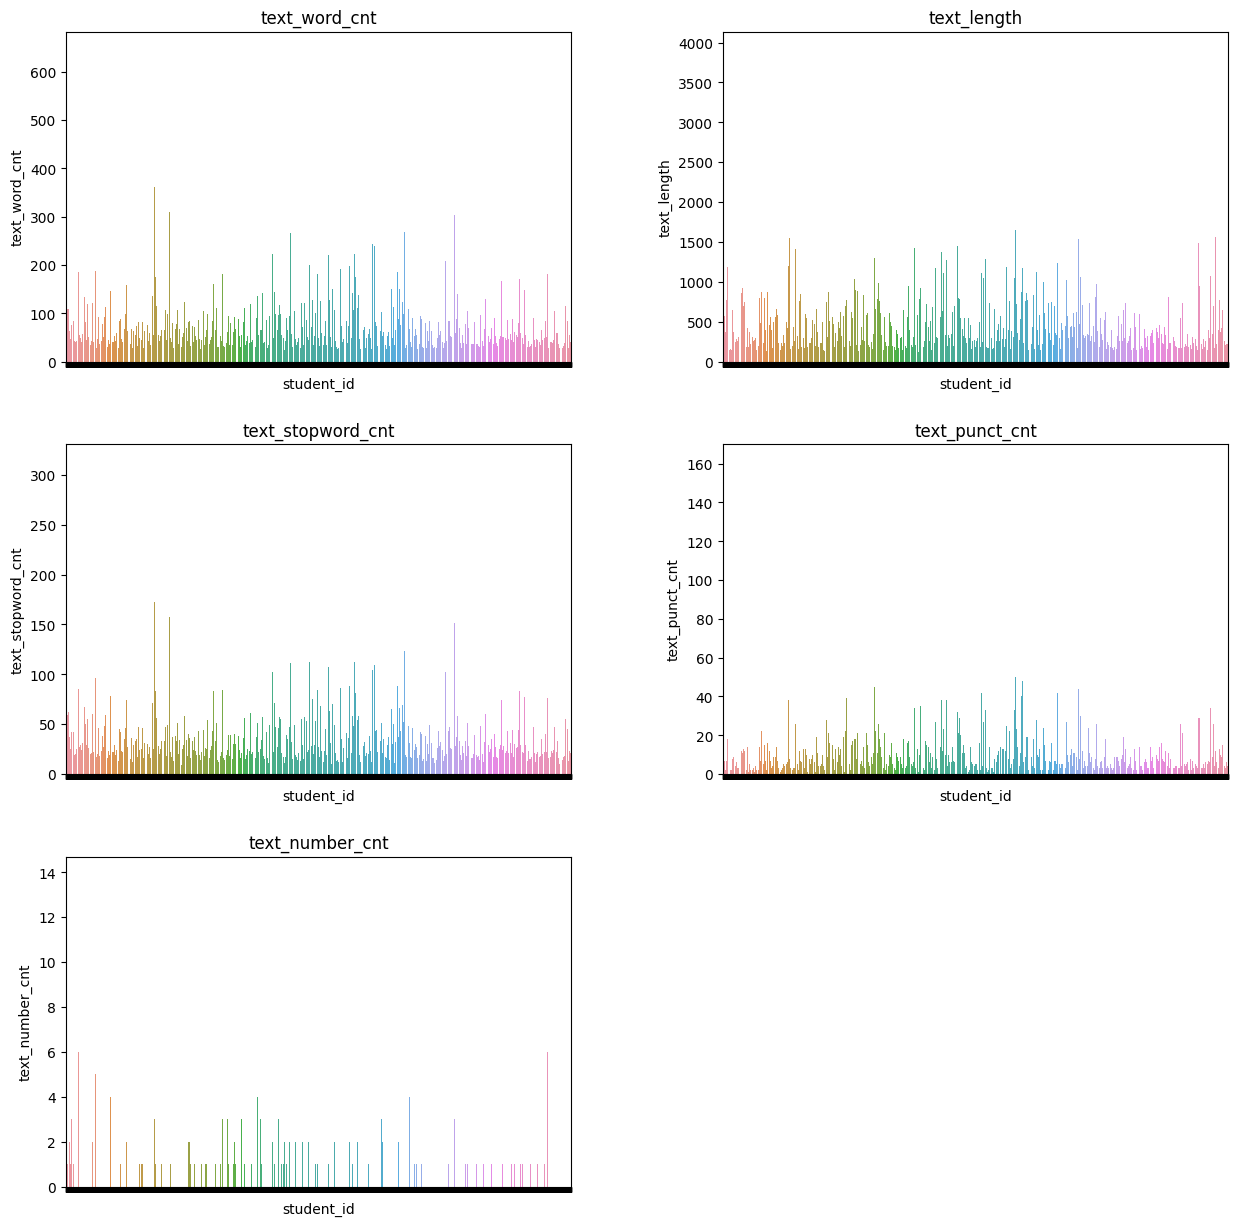

In [27]:
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(FEATURE_COLUMNS):
    row = i//2
    col = i % 2
    bp = sns.barplot(ax=axis[row, col], x=preprocessed_df['student_id'], y=preprocessed_df[column_name])
    bp.set(xticklabels=[])
    axis[row, col].set_title(column_name)
axis[2, 1].set_visible(False)
plt.show()

Now let us split the dataset into training and testing datasets:

In [28]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(preprocessed_df)
train_ds_pd.shape, valid_ds_pd.shape

((5727, 13), (1438, 13))

In [29]:
train_ds_pd.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,61,346,25,3,0
1,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,206,1225,92,30,3
2,0095993991fe,814d6b,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,60,345,27,9,0
3,00c20c6ddd23,814d6b,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,76,451,35,10,0
5,014e2395b3c4,814d6b,The Thrid Wave movement in the school has more...,1.376083,2.389443,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,126,734,67,7,0


There's one more step required before we can train the model. We need to convert the datatset from Pandas format (`pd.DataFrame`) into TensorFlow Datasets format (`tf.data.Dataset`).

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

By default the Random Forest Model is configured to train classification tasks. Since this is a regression problem, we will specify the type of the task (`tfdf.keras.Task.REGRESSION`) as a parameter here.

In [30]:
# `content` label datatset columns
FEATURE_CONTENT = FEATURE_COLUMNS + ['content']

# `wording` label datatset columns
FEATURE_WORDING = FEATURE_COLUMNS + ['wording']

# Convert dataframes to corresponding datasets
content_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd[FEATURE_CONTENT], label='content', task = tfdf.keras.Task.REGRESSION)
wording_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd[FEATURE_WORDING], label='wording', task = tfdf.keras.Task.REGRESSION)

# Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [31]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

# Configure the model

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

# Create a Random Forest

Today, we will use the defaults to create the Random Forest Model while specifiyng the task type as `tfdf.keras.Task.REGRESSION`.

In [32]:
# Create RandomForestModel for label content
model_content = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_content.compile(metrics=["mse"])

# Create RandomForestModel for label wording
model_wording = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
model_wording.compile(metrics=["mse"])

Use /tmp/tmpbbmbn38_ as temporary training directory
Use /tmp/tmpyd0kq_xi as temporary training directory


# Train the model

We will train the model using a one-liner.

Note: you may see a warning about Autograph. You can safely ignore this, it will be fixed in the next release.

In [33]:
# Training RandomForestModel for label content
model_content.fit(x=content_train_ds)

# Training RandomForestModel for label wording
model_wording.fit(x=wording_train_ds)

Reading training dataset...
Training dataset read in 0:00:16.063165. Found 5727 examples.
Training model...


[INFO 23-09-19 11:41:34.9129 CEST kernel.cc:1243] Loading model from path /tmp/tmpbbmbn38_/model/ with prefix 1ea10de02e804a45
[INFO 23-09-19 11:41:37.7427 CEST decision_forest.cc:660] Model loaded with 300 root(s), 461420 node(s), and 5 input feature(s).
[INFO 23-09-19 11:41:37.7428 CEST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-19 11:41:37.7429 CEST kernel.cc:1075] Use fast generic engine


Model trained in 0:00:07.603848
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
Reading training dataset...
Training dataset read in 0:00:00.513309. Found 5727 examples.
Training model...


[INFO 23-09-19 11:41:48.2141 CEST kernel.cc:1243] Loading model from path /tmp/tmpyd0kq_xi/model/ with prefix f7c160849bb34c6f


Model trained in 0:00:06.948900
Compiling model...


[INFO 23-09-19 11:41:50.5895 CEST decision_forest.cc:660] Model loaded with 300 root(s), 448654 node(s), and 5 input feature(s).
[INFO 23-09-19 11:41:50.5895 CEST abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-09-19 11:41:50.5896 CEST kernel.cc:1075] Use fast generic engine


Model compiled.


# Visualize the model
One benefit of tree-based models is that we can easily visualize them. The default number of trees used in the Random Forests is 300. We can select a tree to display below.

In [34]:
# Visualize model_content
tfdf.model_plotter.plot_model_in_colab(model_content, tree_idx=0, max_depth=3)

In [35]:
# Visualize model_content
tfdf.model_plotter.plot_model_in_colab(model_wording, tree_idx=0, max_depth=3)

# Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training the dataset we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model.The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the Root Mean Squared Error (RMSE) evaluated on the out-of-bag dataset according to the number of trees in the model. Let us plot this.

Note: Smaller values are better for this hyperparameter.

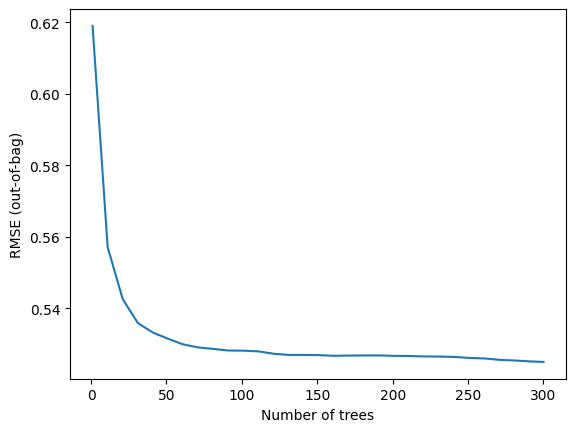

In [36]:
# Plot log data for model_content
logs = model_content.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

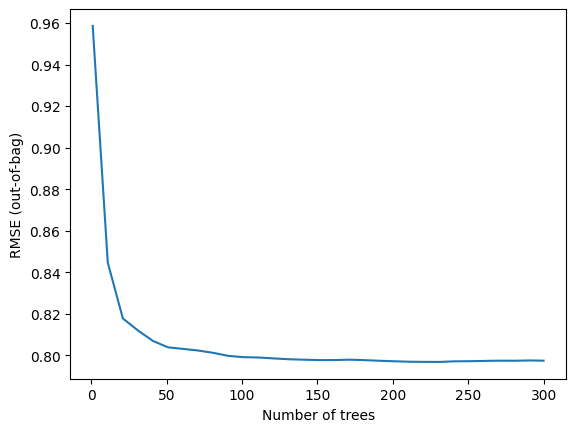

In [37]:
# Plot log data for model_wording
logs = model_wording.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

We can also see some general stats on the OOB dataset:

In [38]:
# General stats for model_content
inspector_content = model_content.make_inspector()
inspector_content.evaluation()

Evaluation(num_examples=5727, accuracy=None, loss=None, rmse=0.5249519125007469, ndcg=None, aucs=None, auuc=None, qini=None)

In [39]:
# General stats for model_wording
inspector_wording = model_wording.make_inspector()
inspector_wording.evaluation()

Evaluation(num_examples=5727, accuracy=None, loss=None, rmse=0.7974107697324655, ndcg=None, aucs=None, auuc=None, qini=None)

Now, let us run an evaluation using the validation dataset.

In [40]:
# Create validation dataset for model_content
valid_ds_content = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd[FEATURE_CONTENT], label="content", task = tfdf.keras.Task.REGRESSION)

# Create validation dataset for model_wording
valid_ds_wording = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd[FEATURE_WORDING], label="wording", task = tfdf.keras.Task.REGRESSION)

# Run evaluation for model_content
evaluation_content = model_content.evaluate(x=valid_ds_content,return_dict=True)
for name, value in evaluation_content.items():
  print(f"{name}: {value:.4f}")

# Run evaluation for model_wording
evaluation_wording = model_wording.evaluate(x=valid_ds_wording,return_dict=True)
for name, value in evaluation_wording.items():
  print(f"{name}: {value:.4f}")

2/2 [==============================] - 1s 79ms/step - loss: 0.0000e+00 - mse: 0.2811
loss: 0.0000
mse: 0.2811
2/2 [==============================] - 0s 73ms/step - loss: 0.0000e+00 - mse: 0.6414
loss: 0.0000
mse: 0.6414


# Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

In [41]:
print(f"Available variable importances for model_content:")
for importance in inspector_content.variable_importances().keys():
  print("\t", importance)

Available variable importances for model_content:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


In [42]:
print(f"Available variable importances for model_wording:")
for importance in inspector_wording.variable_importances().keys():
  print("\t", importance)

Available variable importances for model_wording:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES


As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [43]:
# For model_content.
# Each line is: (feature name, (index of the feature), importance score)
inspector_content.variable_importances()["NUM_AS_ROOT"]

[("text_length" (1; #1), 179.0),
 ("text_word_cnt" (1; #5), 98.0),
 ("text_stopword_cnt" (1; #4), 23.0)]

In [44]:
# For model_wording.
# Each line is: (feature name, (index of the feature), importance score)
inspector_wording.variable_importances()["NUM_AS_ROOT"]

[("text_length" (1; #1), 184.0),
 ("text_word_cnt" (1; #5), 66.0),
 ("text_stopword_cnt" (1; #4), 50.0)]

# Submission

In [46]:
df_test_prompt = pd.read_csv('data/prompts_test.csv')
df_test_summaries = pd.read_csv('data/summaries_test.csv')

In [47]:
df_test = df_test_summaries.merge(df_test_prompt, on='prompt_id')

In [48]:
df_test.head()

,student_id,prompt_id,text,prompt_question,prompt_title,prompt_text
0,000000ffffff,abc123,Example text 1,Summarize...,Example Title 1,Heading\nText...
1,222222cccccc,abc123,Example text 3,Summarize...,Example Title 1,Heading\nText...
2,111111eeeeee,def789,Example text 2,Summarize...,Example Title 2,Heading\nText...
3,333333dddddd,def789,Example text 4,Summarize...,Example Title 2,Heading\nText...


In [49]:
processed_test_df = feature_engineer(df_test)

In [50]:
processed_test_df.head()

,student_id,prompt_id,text,prompt_question,prompt_title,prompt_text,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt
0,000000ffffff,abc123,Example text 1,Summarize...,Example Title 1,Heading\nText...,3,14,0,0,1
1,222222cccccc,abc123,Example text 3,Summarize...,Example Title 1,Heading\nText...,3,14,0,0,1
2,111111eeeeee,def789,Example text 2,Summarize...,Example Title 2,Heading\nText...,3,14,0,0,1
3,333333dddddd,def789,Example text 4,Summarize...,Example Title 2,Heading\nText...,3,14,0,0,1


In [51]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(processed_test_df[FEATURE_COLUMNS], task = tfdf.keras.Task.REGRESSION)

In [52]:
processed_test_df['content'] = model_content.predict(test_ds)
processed_test_df['wording'] = model_wording.predict(test_ds)

1/1 [==============================] - 0s 271ms/step


In [53]:
processed_test_df.head()

,student_id,prompt_id,text,prompt_question,prompt_title,prompt_text,text_word_cnt,text_length,text_stopword_cnt,text_punct_cnt,text_number_cnt,content,wording
0,000000ffffff,abc123,Example text 1,Summarize...,Example Title 1,Heading\nText...,3,14,0,0,1,-1.399075,-1.406867
1,222222cccccc,abc123,Example text 3,Summarize...,Example Title 1,Heading\nText...,3,14,0,0,1,-1.399075,-1.406867
2,111111eeeeee,def789,Example text 2,Summarize...,Example Title 2,Heading\nText...,3,14,0,0,1,-1.399075,-1.406867
3,333333dddddd,def789,Example text 4,Summarize...,Example Title 2,Heading\nText...,3,14,0,0,1,-1.399075,-1.406867


In [54]:
processed_test_df[['student_id', 'content', 'wording']].to_csv('submission.csv',index=False)
display(pd.read_csv('submission.csv'))

,student_id,content,wording
0,000000ffffff,-1.399075,-1.406867
1,222222cccccc,-1.399075,-1.406867
2,111111eeeeee,-1.399075,-1.406867
3,333333dddddd,-1.399075,-1.406867
